In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\NOK_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'nok', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640602,0,-0.445346
4,2021-01-05,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.993208,1,-0.006816


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     205 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: NOK Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['4Dir', 'Daily%Change', '6Dir', '2Dir', 'Dir', 'SD_log', 'Open', '3Dir', 'SD', '7D%Change', '4D%Change', '6D%Change', '5Dir', '7Dir', 'Low', 'High', '2D%Change', 'Volume', '3D%Change', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,3.98,2,3.617580,1.0,26065000.0,1.0,3.94,-0.742568,3.93,2.557548,...,2.035628,-0.072462,0.0,0.501259,1.0,1.0,-0.742568,0.930101,3.084836,4.01
8,4.09,3,-0.748135,1.0,33763400.0,0.0,3.91,-0.250626,3.91,2.313622,...,2.842381,-0.362276,0.0,1.272263,1.0,0.0,-1.485147,0.696090,-1.485147,3.98
9,4.08,4,2.763822,1.0,93198600.0,1.0,4.12,4.071249,4.07,1.237628,...,1.995010,0.807953,1.0,5.684762,1.0,1.0,2.506269,2.243312,1.237628,4.09
10,4.13,1,-0.244504,1.0,36639300.0,0.0,4.09,5.426358,4.04,0.990098,...,2.512560,-0.399468,1.0,1.745628,1.0,1.0,3.816790,0.670677,2.255637,4.08
11,4.20,2,1.225495,1.0,40539400.0,1.0,4.07,2.992516,4.03,3.508775,...,0.977994,0.221475,1.0,3.768847,1.0,1.0,6.718352,1.247917,5.089060,4.13


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,6.14,2,1.015227,0.0,15204500.0,1.0,5.91,-2.610119,5.89,-0.830568,...,-1.100973,0.0,-1.485151,0.0,0.0,0.167781,0.332547,-0.167228,5.97,6.14
246,6.19,3,2.847573,1.0,20772700.0,1.0,5.99,1.320131,5.98,2.675583,...,-0.781365,1.0,2.163055,1.0,1.0,0.163128,0.457781,3.020131,6.14,6.19
247,6.34,0,0.814335,1.0,13625900.0,1.0,6.20,2.995005,6.18,3.859061,...,-0.411963,1.0,4.737736,1.0,1.0,2.145216,0.662349,0.978792,6.19,6.34
248,6.30,1,2.423265,1.0,15681700.0,1.0,6.28,7.275809,6.24,3.425775,...,-0.182087,1.0,6.197661,1.0,1.0,5.490847,0.833529,4.620466,6.34,6.30
249,6.29,2,-0.630914,1.0,12315300.0,0.0,6.37,5.527645,6.28,3.960400,...,-1.613045,1.0,2.605869,1.0,1.0,6.598991,0.199280,4.825290,6.30,6.29


In [7]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.377289331223722
0.377289331223722


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'NOK_woSentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0545
Epoch 1: val_loss improved from inf to 0.01600, saving model to NOK_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 6s 133ms/step - loss: 0.0436 - val_loss: 0.0160
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0136
Epoch 2: val_loss improved from 0.01600 to 0.00622, saving model to NOK_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 1s 67ms/step - loss: 0.0136 - val_loss: 0.0062
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0102
Epoch 3: val_loss improved from 0.00622 to 0.00436, saving model to NOK_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 25ms/step - loss: 0.0097 - val_loss: 0.0044
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0078
Epoch 4: val_loss improved from 0.00436 to 0.00359, saving model to NOK_woSentiment_ClosePric

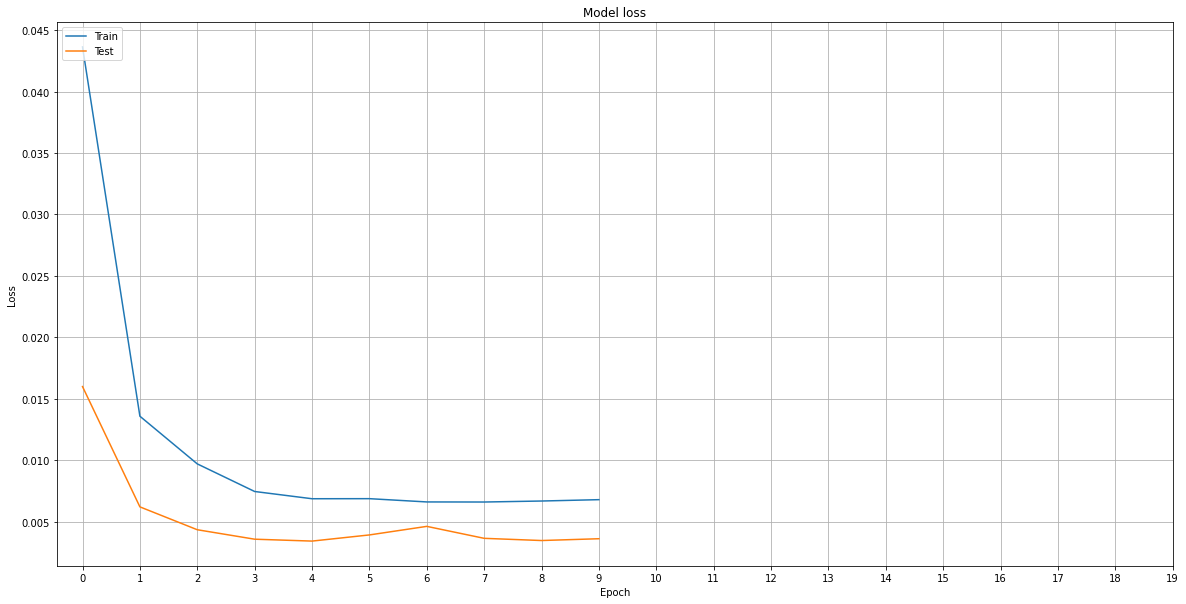

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.14
Mean Absolute Percentage Error (MAPE): 2.35 %
Median Absolute Percentage Error (MDAPE): 2.23 %


,MAE,MAPE,MDAPE
0,0.136601,2.351611,2.234886


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

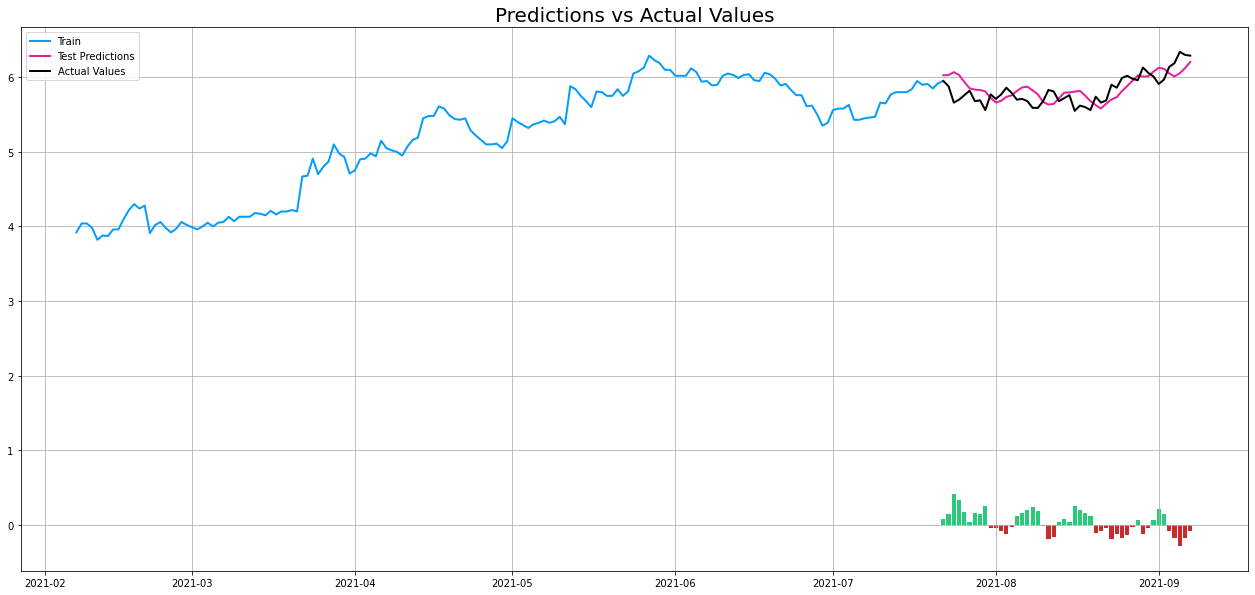

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['4Dir', 'Daily%Change', '6Dir', '2Dir', 'Dir', 'SD_log', 'Open', '3Dir', 'SD', '7D%Change', '4D%Change', '6D%Change', '5Dir', '7Dir', 'Low', 'High', '2D%Change', 'Volume', '3D%Change', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,3.98,2,3.617580,1.0,26065000.0,1.0,3.94,-0.742568,3.93,2.557548,...,2.035628,-0.072462,0.0,0.501259,1.0,1.0,-0.742568,0.930101,3.084836,4.01
8,4.09,3,-0.748135,1.0,33763400.0,0.0,3.91,-0.250626,3.91,2.313622,...,2.842381,-0.362276,0.0,1.272263,1.0,0.0,-1.485147,0.696090,-1.485147,3.98
9,4.08,4,2.763822,1.0,93198600.0,1.0,4.12,4.071249,4.07,1.237628,...,1.995010,0.807953,1.0,5.684762,1.0,1.0,2.506269,2.243312,1.237628,4.09
10,4.13,1,-0.244504,1.0,36639300.0,0.0,4.09,5.426358,4.04,0.990098,...,2.512560,-0.399468,1.0,1.745628,1.0,1.0,3.816790,0.670677,2.255637,4.08
11,4.20,2,1.225495,1.0,40539400.0,1.0,4.07,2.992516,4.03,3.508775,...,0.977994,0.221475,1.0,3.768847,1.0,1.0,6.718352,1.247917,5.089060,4.13


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,6.14,2,1.015227,0.0,15204500.0,1.0,5.91,-2.610119,5.89,-0.830568,...,-1.100973,0.0,-1.485151,0.0,0.0,0.167781,0.332547,-0.167228,5.97,6.14
246,6.19,3,2.847573,1.0,20772700.0,1.0,5.99,1.320131,5.98,2.675583,...,-0.781365,1.0,2.163055,1.0,1.0,0.163128,0.457781,3.020131,6.14,6.19
247,6.34,0,0.814335,1.0,13625900.0,1.0,6.20,2.995005,6.18,3.859061,...,-0.411963,1.0,4.737736,1.0,1.0,2.145216,0.662349,0.978792,6.19,6.34
248,6.30,1,2.423265,1.0,15681700.0,1.0,6.28,7.275809,6.24,3.425775,...,-0.182087,1.0,6.197661,1.0,1.0,5.490847,0.833529,4.620466,6.34,6.30
249,6.29,2,-0.630914,1.0,12315300.0,0.0,6.37,5.527645,6.28,3.960400,...,-1.613045,1.0,2.605869,1.0,1.0,6.598991,0.199280,4.825290,6.30,6.29


In [17]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.377289331223722
0.377289331223722


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'NOK_woSentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/12 [========================>.....] - ETA: 0s - loss: 0.1088 
Epoch 1: val_loss improved from inf to 0.04315, saving model to NOK_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 9s 108ms/step - loss: 0.1003 - val_loss: 0.0431
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0275
Epoch 2: val_loss improved from 0.04315 to 0.02540, saving model to NOK_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 19ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0135
Epoch 3: val_loss improved from 0.02540 to 0.00942, saving model to NOK_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 18ms/step - loss: 0.0128 - val_loss: 0.0094
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0112
Epoch 4: val_loss improved from 0.00942 to 0.00686, saving model to NOK_woSentiment_ClosePrice_Normalized.h

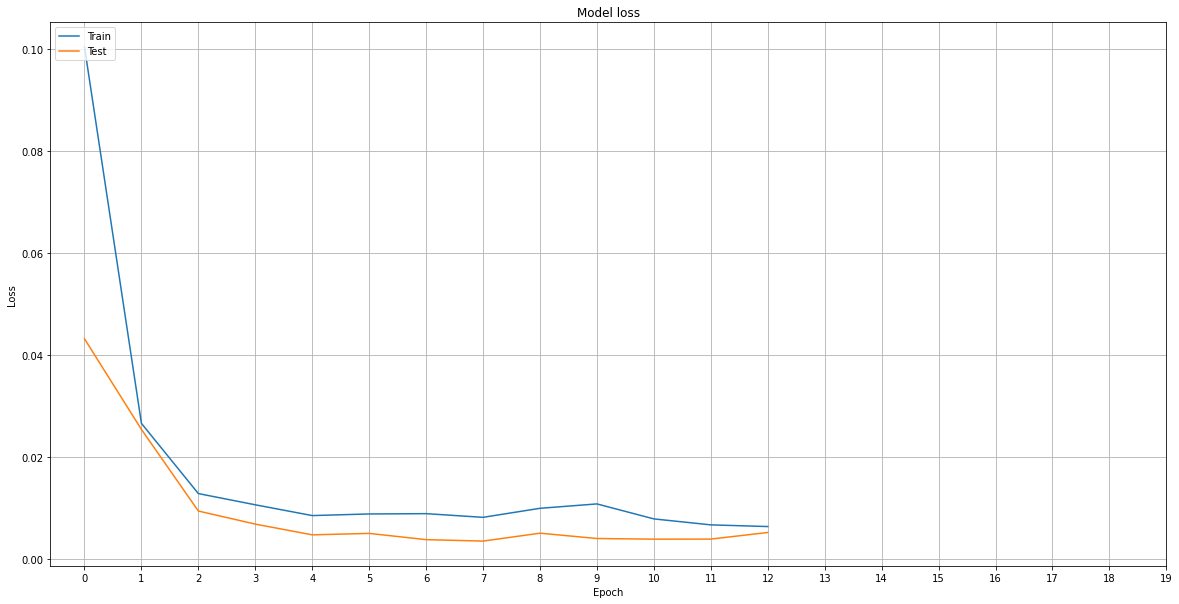

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.14
Mean Absolute Percentage Error (MAPE): 2.37 %
Median Absolute Percentage Error (MDAPE): 2.35 %


,MAE,MAPE,MDAPE
0,0.137467,2.367122,2.352729


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

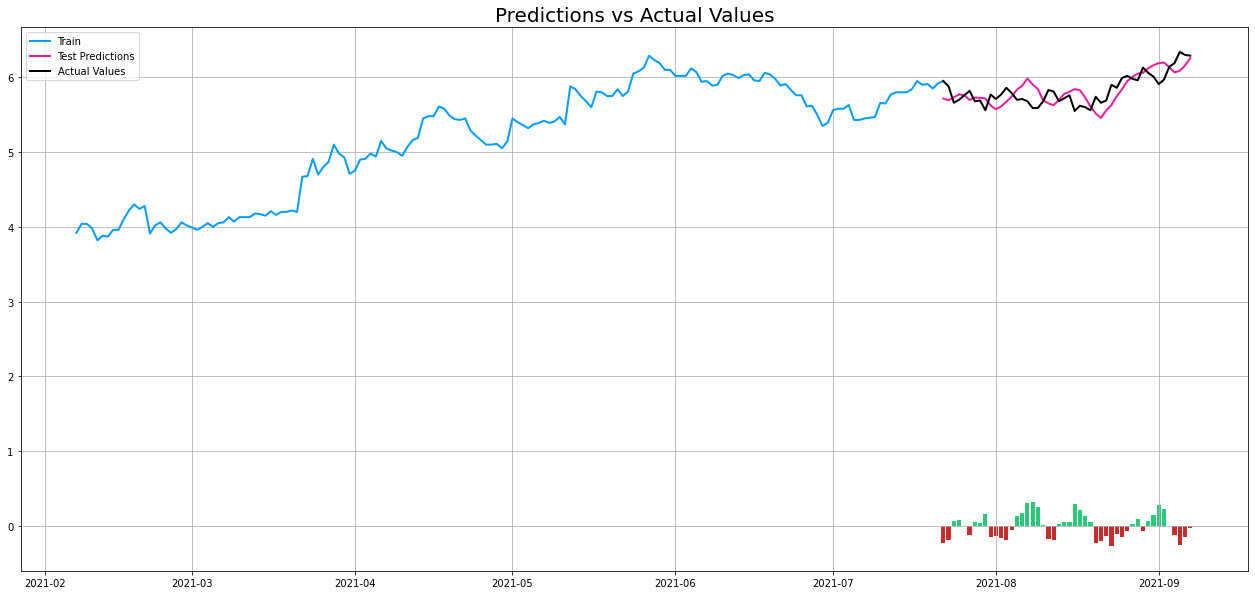

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: NOK Daily%Change

### Without Normalization

In [25]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['4Dir', '3D%Change', '6Dir', '2Dir', 'Dir', 'SD_log', 'Open', '3Dir', 'SD', '7D%Change', '4D%Change', '6D%Change', '5Dir', '7Dir', 'Low', 'High', '2D%Change', 'Volume', 'Close', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-0.748135,2,3.617580,1.0,26065000.0,1.0,3.94,-0.742568,3.93,2.557548,...,2.035628,-0.072462,0.0,0.501259,1.0,1.0,-0.742568,0.930101,3.084836,4.01
8,2.763822,3,-0.748135,1.0,33763400.0,0.0,3.91,-0.250626,3.91,2.313622,...,2.842381,-0.362276,0.0,1.272263,1.0,0.0,-1.485147,0.696090,-1.485147,3.98
9,-0.244504,4,2.763822,1.0,93198600.0,1.0,4.12,4.071249,4.07,1.237628,...,1.995010,0.807953,1.0,5.684762,1.0,1.0,2.506269,2.243312,1.237628,4.09
10,1.225495,1,-0.244504,1.0,36639300.0,0.0,4.09,5.426358,4.04,0.990098,...,2.512560,-0.399468,1.0,1.745628,1.0,1.0,3.816790,0.670677,2.255637,4.08
11,1.694908,2,1.225495,1.0,40539400.0,1.0,4.07,2.992516,4.03,3.508775,...,0.977994,0.221475,1.0,3.768847,1.0,1.0,6.718352,1.247917,5.089060,4.13


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,2.847573,2,1.015227,0.0,15204500.0,1.0,5.91,-2.610119,5.89,-0.830568,...,-1.100973,0.0,-1.485151,0.0,0.0,0.167781,0.332547,-0.167228,5.97,2.847573
246,0.814335,3,2.847573,1.0,20772700.0,1.0,5.99,1.320131,5.98,2.675583,...,-0.781365,1.0,2.163055,1.0,1.0,0.163128,0.457781,3.020131,6.14,0.814335
247,2.423265,0,0.814335,1.0,13625900.0,1.0,6.20,2.995005,6.18,3.859061,...,-0.411963,1.0,4.737736,1.0,1.0,2.145216,0.662349,0.978792,6.19,2.423265
248,-0.630914,1,2.423265,1.0,15681700.0,1.0,6.28,7.275809,6.24,3.425775,...,-0.182087,1.0,6.197661,1.0,1.0,5.490847,0.833529,4.620466,6.34,-0.630914
249,-0.158734,2,-0.630914,1.0,12315300.0,0.0,6.37,5.527645,6.28,3.960400,...,-1.613045,1.0,2.605869,1.0,1.0,6.598991,0.199280,4.825290,6.30,-0.158734


In [27]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.6560493994145682
0.6560493994145682


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'NOK_woSentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0574 
Epoch 1: val_loss improved from inf to 0.01118, saving model to NOK_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 17s 444ms/step - loss: 0.0484 - val_loss: 0.0112
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0103
Epoch 2: val_loss improved from 0.01118 to 0.00334, saving model to NOK_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 1s 60ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 3/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0076
Epoch 3: val_loss did not improve from 0.00334
12/12 [==============================] - 0s 37ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0035
Epoch 4: val_loss improved from 0.00334 to 0.00201, saving model to NOK_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 

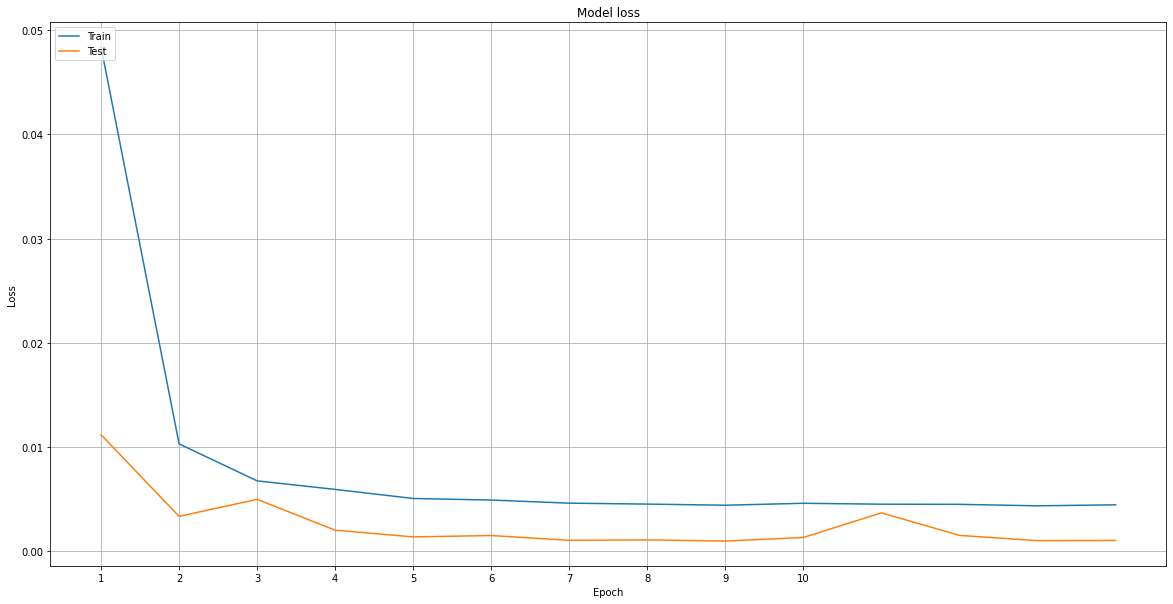

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 1.67
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 116.67 %


,MAE,MAPE,MDAPE
0,1.673073,inf,116.666401


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

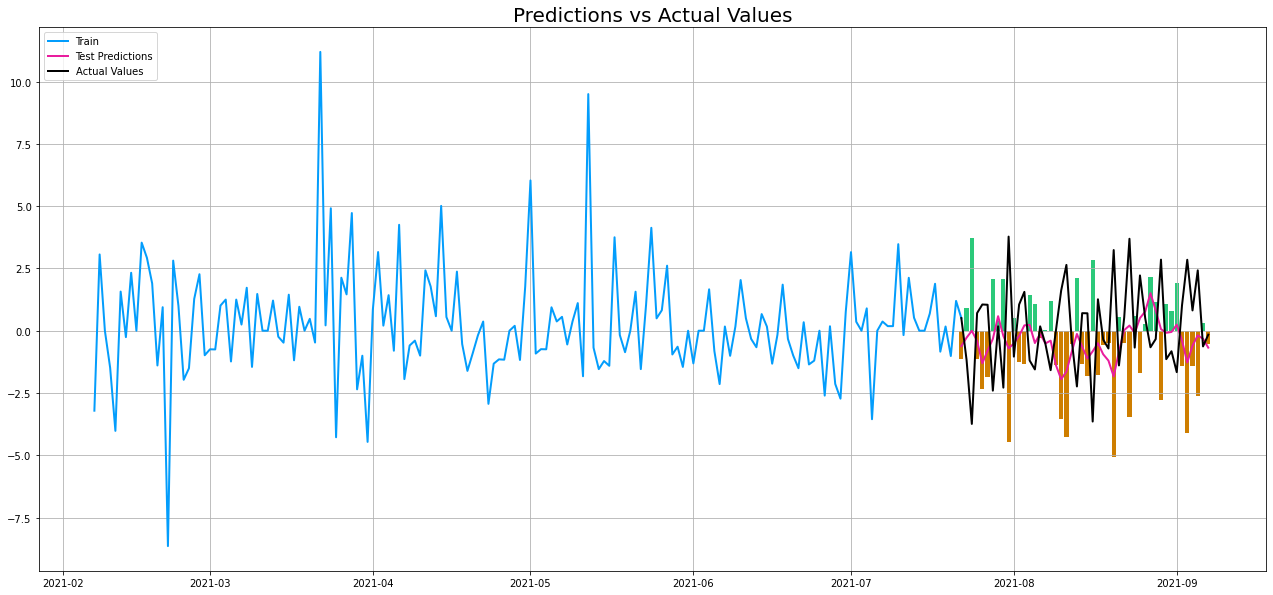

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [35]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['4Dir', '3D%Change', '6Dir', '2Dir', 'Dir', 'SD_log', 'Open', '3Dir', 'SD', '7D%Change', '4D%Change', '6D%Change', '5Dir', '7Dir', 'Low', 'High', '2D%Change', 'Volume', 'Close', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-0.748135,2,3.617580,1.0,26065000.0,1.0,3.94,-0.742568,3.93,2.557548,...,2.035628,-0.072462,0.0,0.501259,1.0,1.0,-0.742568,0.930101,3.084836,4.01
8,2.763822,3,-0.748135,1.0,33763400.0,0.0,3.91,-0.250626,3.91,2.313622,...,2.842381,-0.362276,0.0,1.272263,1.0,0.0,-1.485147,0.696090,-1.485147,3.98
9,-0.244504,4,2.763822,1.0,93198600.0,1.0,4.12,4.071249,4.07,1.237628,...,1.995010,0.807953,1.0,5.684762,1.0,1.0,2.506269,2.243312,1.237628,4.09
10,1.225495,1,-0.244504,1.0,36639300.0,0.0,4.09,5.426358,4.04,0.990098,...,2.512560,-0.399468,1.0,1.745628,1.0,1.0,3.816790,0.670677,2.255637,4.08
11,1.694908,2,1.225495,1.0,40539400.0,1.0,4.07,2.992516,4.03,3.508775,...,0.977994,0.221475,1.0,3.768847,1.0,1.0,6.718352,1.247917,5.089060,4.13


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,2.847573,2,1.015227,0.0,15204500.0,1.0,5.91,-2.610119,5.89,-0.830568,...,-1.100973,0.0,-1.485151,0.0,0.0,0.167781,0.332547,-0.167228,5.97,2.847573
246,0.814335,3,2.847573,1.0,20772700.0,1.0,5.99,1.320131,5.98,2.675583,...,-0.781365,1.0,2.163055,1.0,1.0,0.163128,0.457781,3.020131,6.14,0.814335
247,2.423265,0,0.814335,1.0,13625900.0,1.0,6.20,2.995005,6.18,3.859061,...,-0.411963,1.0,4.737736,1.0,1.0,2.145216,0.662349,0.978792,6.19,2.423265
248,-0.630914,1,2.423265,1.0,15681700.0,1.0,6.28,7.275809,6.24,3.425775,...,-0.182087,1.0,6.197661,1.0,1.0,5.490847,0.833529,4.620466,6.34,-0.630914
249,-0.158734,2,-0.630914,1.0,12315300.0,0.0,6.37,5.527645,6.28,3.960400,...,-1.613045,1.0,2.605869,1.0,1.0,6.598991,0.199280,4.825290,6.30,-0.158734


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.6560493994145682
0.6560493994145682


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'NOK_woSentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0576
Epoch 1: val_loss improved from inf to 0.01106, saving model to NOK_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 6s 115ms/step - loss: 0.0515 - val_loss: 0.0111
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss improved from 0.01106 to 0.00163, saving model to NOK_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 23ms/step - loss: 0.0081 - val_loss: 0.0016
Epoch 3/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0069
Epoch 3: val_loss did not improve from 0.00163
12/12 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0069
Epoch 4: val_loss did not improve from 0.00163
12/12 [==============================] - 0s 18ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 5/100
 9/12 [==============

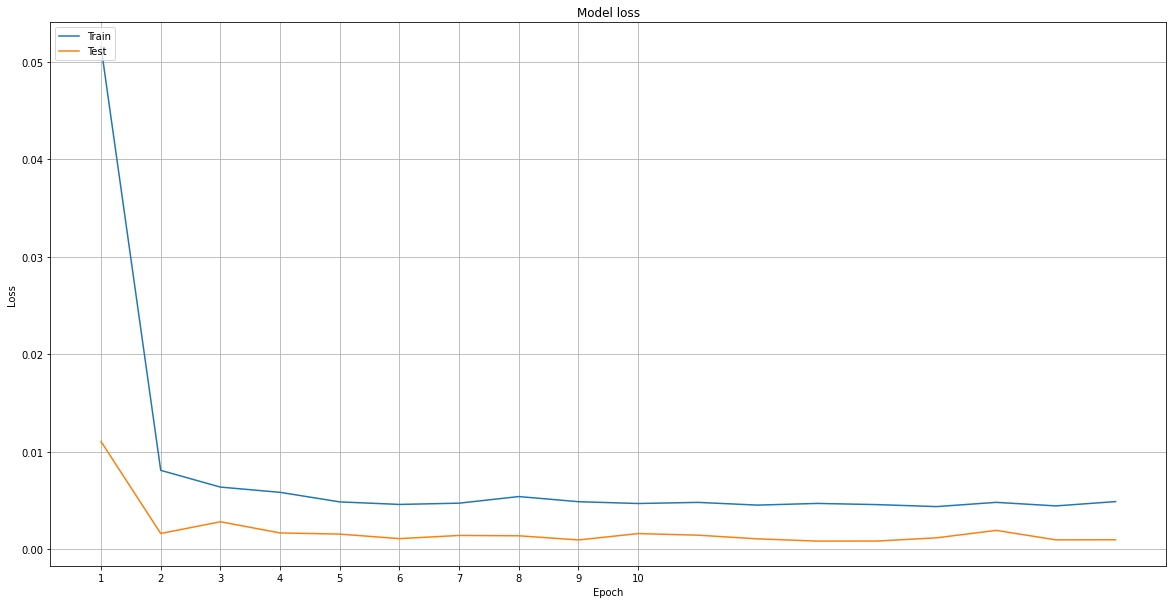

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 1.65
Mean Absolute Percentage Error (MAPE): 174476731937423.56 %
Median Absolute Percentage Error (MDAPE): 126.18 %


,MAE,MAPE,MDAPE
0,1.646051,1.744767e+14,126.175242


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

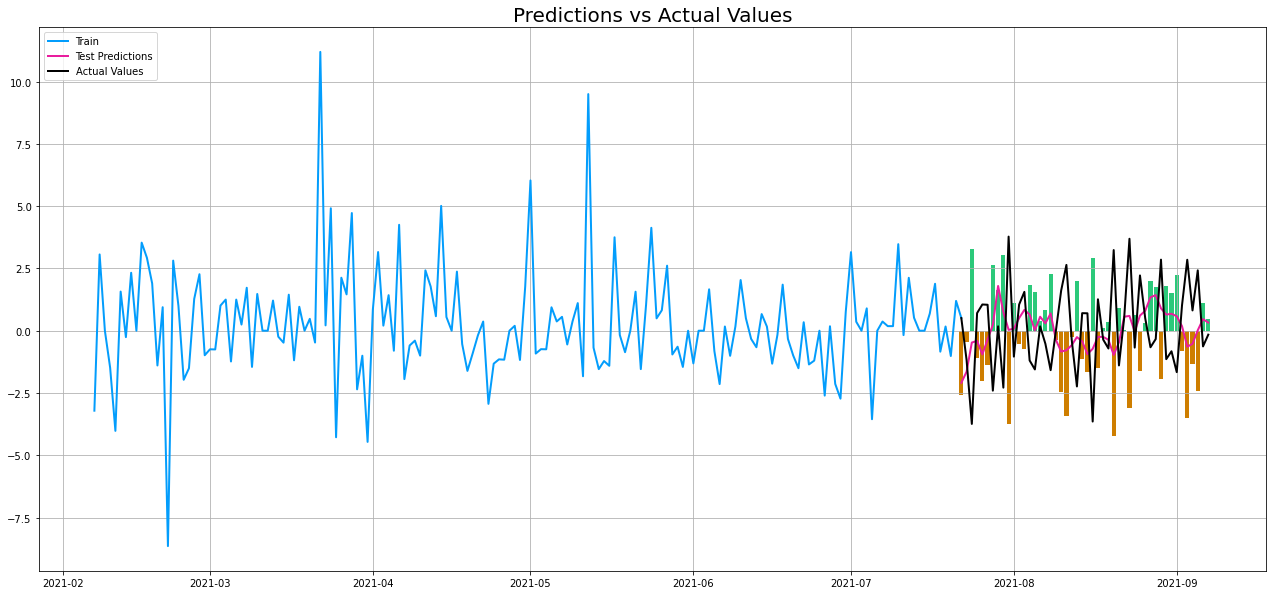

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: NOK SD

### Without Normalization

In [45]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['4Dir', '3D%Change', 'Daily%Change', '6Dir', '2Dir', 'Dir', 'SD_log', 'Open', '3Dir', '7D%Change', '4D%Change', '6D%Change', '5Dir', '7Dir', 'Low', 'High', '2D%Change', 'Volume', 'Close', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,0.696090,2,3.617580,1.0,26065000.0,1.0,3.94,-0.742568,3.93,2.557548,...,2.035628,-0.072462,0.0,0.501259,1.0,1.0,-0.742568,0.930101,3.084836,4.01
8,2.243312,3,-0.748135,1.0,33763400.0,0.0,3.91,-0.250626,3.91,2.313622,...,2.842381,-0.362276,0.0,1.272263,1.0,0.0,-1.485147,0.696090,-1.485147,3.98
9,0.670677,4,2.763822,1.0,93198600.0,1.0,4.12,4.071249,4.07,1.237628,...,1.995010,0.807953,1.0,5.684762,1.0,1.0,2.506269,2.243312,1.237628,4.09
10,1.247917,1,-0.244504,1.0,36639300.0,0.0,4.09,5.426358,4.04,0.990098,...,2.512560,-0.399468,1.0,1.745628,1.0,1.0,3.816790,0.670677,2.255637,4.08
11,0.822854,2,1.225495,1.0,40539400.0,1.0,4.07,2.992516,4.03,3.508775,...,0.977994,0.221475,1.0,3.768847,1.0,1.0,6.718352,1.247917,5.089060,4.13


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,0.457781,2,1.015227,0.0,15204500.0,1.0,5.91,-2.610119,5.89,-0.830568,...,-1.100973,0.0,-1.485151,0.0,0.0,0.167781,0.332547,-0.167228,5.97,0.457781
246,0.662349,3,2.847573,1.0,20772700.0,1.0,5.99,1.320131,5.98,2.675583,...,-0.781365,1.0,2.163055,1.0,1.0,0.163128,0.457781,3.020131,6.14,0.662349
247,0.833529,0,0.814335,1.0,13625900.0,1.0,6.20,2.995005,6.18,3.859061,...,-0.411963,1.0,4.737736,1.0,1.0,2.145216,0.662349,0.978792,6.19,0.833529
248,0.199280,1,2.423265,1.0,15681700.0,1.0,6.28,7.275809,6.24,3.425775,...,-0.182087,1.0,6.197661,1.0,1.0,5.490847,0.833529,4.620466,6.34,0.199280
249,0.156238,2,-0.630914,1.0,12315300.0,0.0,6.37,5.527645,6.28,3.960400,...,-1.613045,1.0,2.605869,1.0,1.0,6.598991,0.199280,4.825290,6.30,0.156238


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.46027157019084836
0.46027157019084836


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'NOK_woSentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0546
Epoch 1: val_loss improved from inf to 0.00619, saving model to NOK_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 6s 121ms/step - loss: 0.0458 - val_loss: 0.0062
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0167
Epoch 2: val_loss improved from 0.00619 to 0.00127, saving model to NOK_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 0s 23ms/step - loss: 0.0137 - val_loss: 0.0013
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0146
Epoch 3: val_loss improved from 0.00127 to 0.00085, saving model to NOK_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 0s 22ms/step - loss: 0.0118 - val_loss: 8.4756e-04
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0088
Epoch 4: val_loss did not improve from 0.00085
12/12 [==============================] - 0s 18ms/step - loss: 0.01

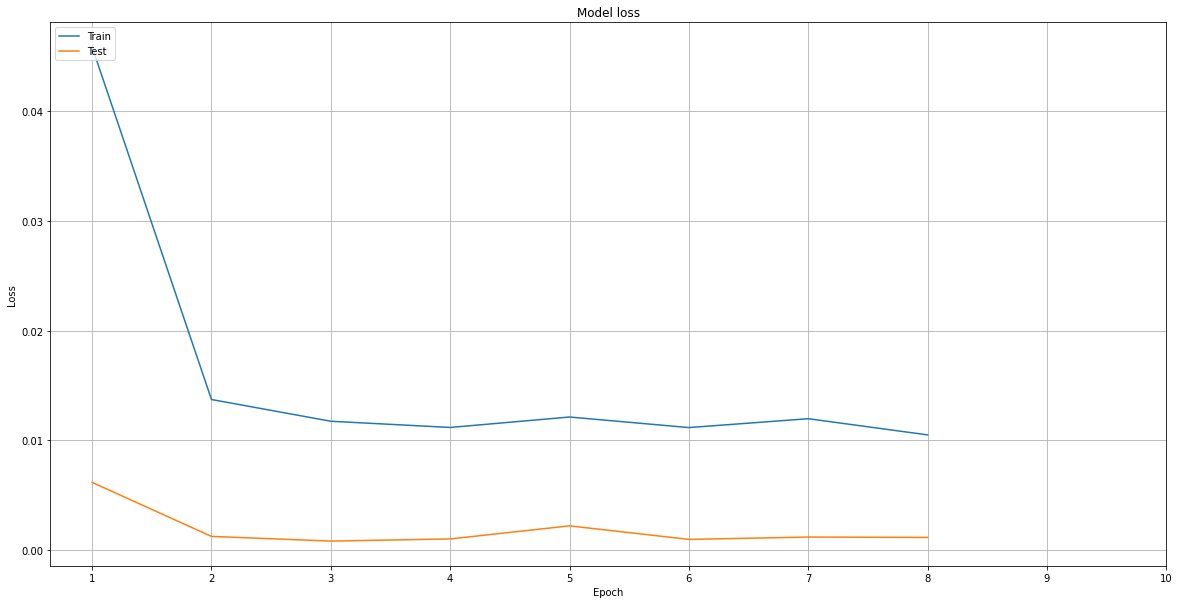

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.23
Mean Absolute Percentage Error (MAPE): 46.97 %
Median Absolute Percentage Error (MDAPE): 32.3 %


,MAE,MAPE,MDAPE
0,0.231319,46.965595,32.298861


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

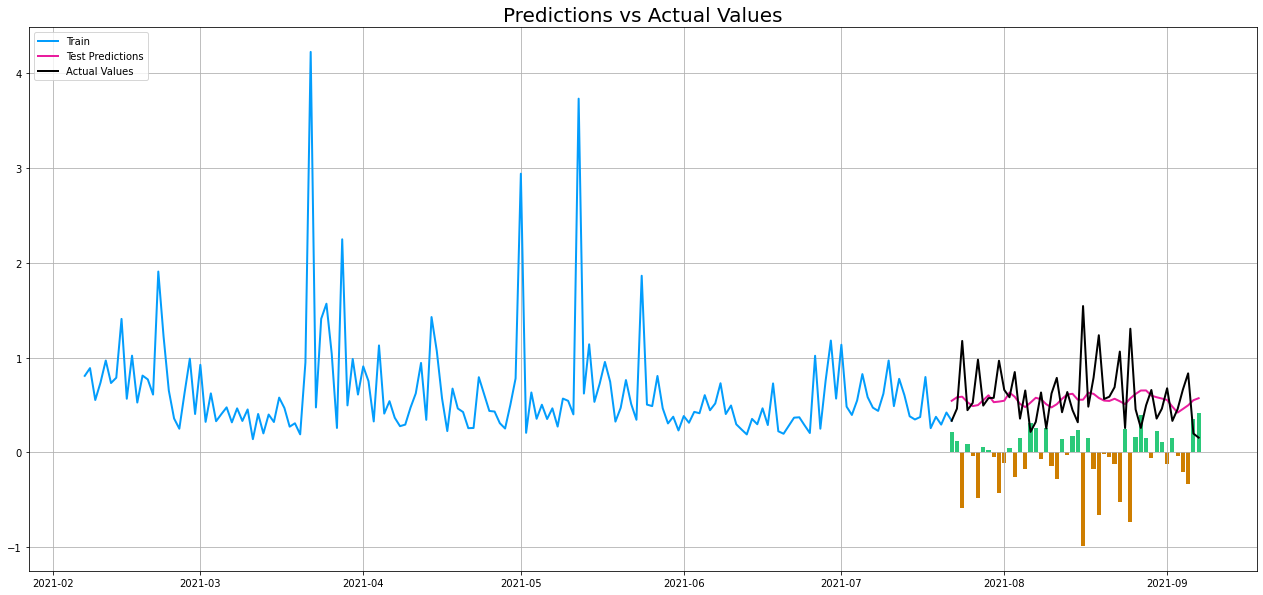

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [55]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['4Dir', '3D%Change', 'Daily%Change', '6Dir', '2Dir', 'Dir', 'SD_log', 'Open', '3Dir', '7D%Change', '4D%Change', '6D%Change', '5Dir', '7Dir', 'Low', 'High', '2D%Change', 'Volume', 'Close', '5D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,0.696090,2,3.617580,1.0,26065000.0,1.0,3.94,-0.742568,3.93,2.557548,...,2.035628,-0.072462,0.0,0.501259,1.0,1.0,-0.742568,0.930101,3.084836,4.01
8,2.243312,3,-0.748135,1.0,33763400.0,0.0,3.91,-0.250626,3.91,2.313622,...,2.842381,-0.362276,0.0,1.272263,1.0,0.0,-1.485147,0.696090,-1.485147,3.98
9,0.670677,4,2.763822,1.0,93198600.0,1.0,4.12,4.071249,4.07,1.237628,...,1.995010,0.807953,1.0,5.684762,1.0,1.0,2.506269,2.243312,1.237628,4.09
10,1.247917,1,-0.244504,1.0,36639300.0,0.0,4.09,5.426358,4.04,0.990098,...,2.512560,-0.399468,1.0,1.745628,1.0,1.0,3.816790,0.670677,2.255637,4.08
11,0.822854,2,1.225495,1.0,40539400.0,1.0,4.07,2.992516,4.03,3.508775,...,0.977994,0.221475,1.0,3.768847,1.0,1.0,6.718352,1.247917,5.089060,4.13


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,0.457781,2,1.015227,0.0,15204500.0,1.0,5.91,-2.610119,5.89,-0.830568,...,-1.100973,0.0,-1.485151,0.0,0.0,0.167781,0.332547,-0.167228,5.97,0.457781
246,0.662349,3,2.847573,1.0,20772700.0,1.0,5.99,1.320131,5.98,2.675583,...,-0.781365,1.0,2.163055,1.0,1.0,0.163128,0.457781,3.020131,6.14,0.662349
247,0.833529,0,0.814335,1.0,13625900.0,1.0,6.20,2.995005,6.18,3.859061,...,-0.411963,1.0,4.737736,1.0,1.0,2.145216,0.662349,0.978792,6.19,0.833529
248,0.199280,1,2.423265,1.0,15681700.0,1.0,6.28,7.275809,6.24,3.425775,...,-0.182087,1.0,6.197661,1.0,1.0,5.490847,0.833529,4.620466,6.34,0.199280
249,0.156238,2,-0.630914,1.0,12315300.0,0.0,6.37,5.527645,6.28,3.960400,...,-1.613045,1.0,2.605869,1.0,1.0,6.598991,0.199280,4.825290,6.30,0.156238


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.46027157019084836
0.46027157019084836


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'NOK_woSentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0258
Epoch 1: val_loss improved from inf to 0.00172, saving model to NOK_woSentiment_SD_Normalized.h5
12/12 [==============================] - 6s 129ms/step - loss: 0.0210 - val_loss: 0.0017
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0127  
Epoch 2: val_loss did not improve from 0.00172
12/12 [==============================] - 0s 23ms/step - loss: 0.0123 - val_loss: 0.0046
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0129
Epoch 3: val_loss did not improve from 0.00172
12/12 [==============================] - 0s 22ms/step - loss: 0.0129 - val_loss: 0.0024
Epoch 4/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0086
Epoch 4: val_loss improved from 0.00172 to 0.00142, saving model to NOK_woSentiment_SD_Normalized.h5
12/12 [==============================] - 0s 29ms/step - loss: 0.0114 - val_loss: 0.0014
Epoch 5/100
10/12 [========================>.....

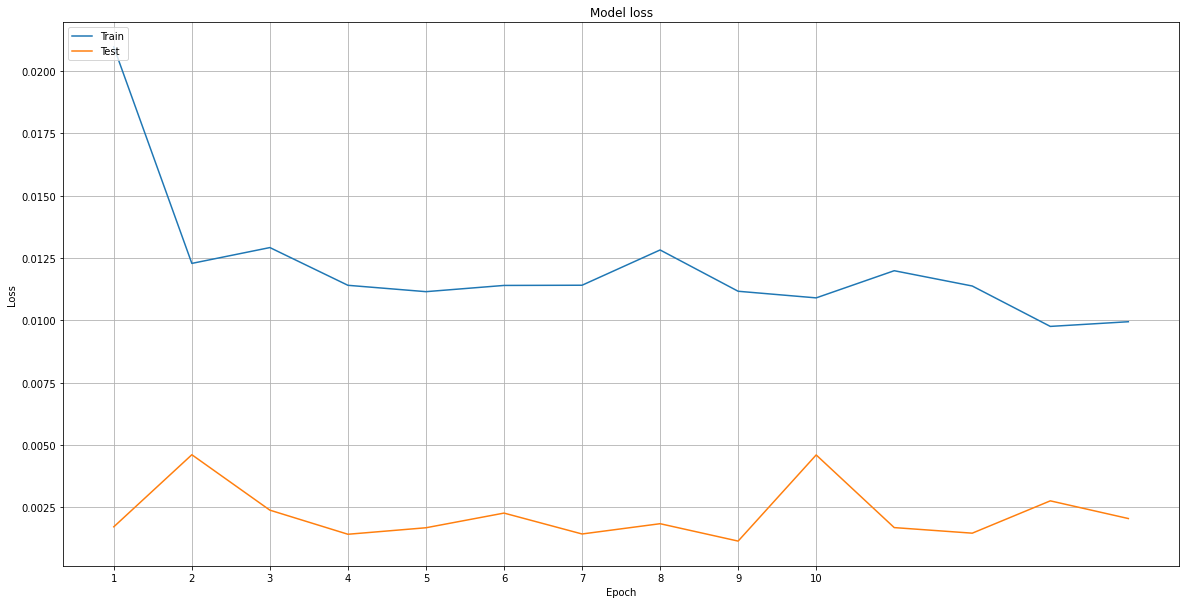

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.28
Mean Absolute Percentage Error (MAPE): 56.95 %
Median Absolute Percentage Error (MDAPE): 34.38 %


,MAE,MAPE,MDAPE
0,0.27807,56.952562,34.384724


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

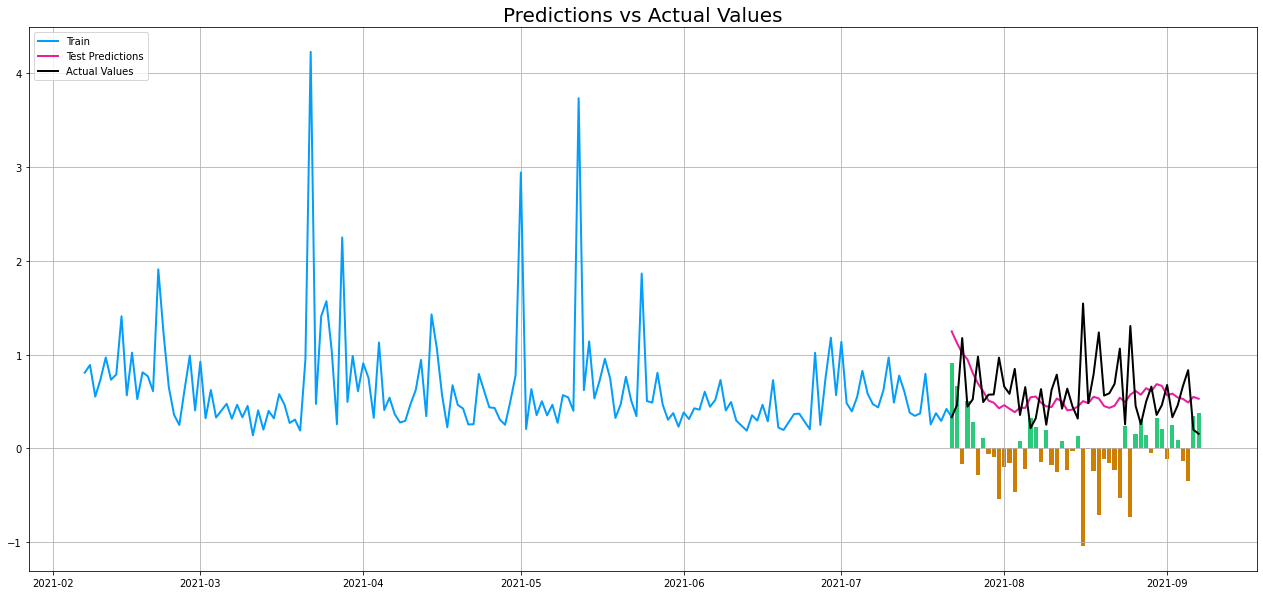

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()